In [1]:
# %%capture cap
!pip install -q ipywidgets
!pip install -q autogluon scikit-learn==1.5.2 
!apt-get install -q -y graphviz graphviz-dev && pip install -q pydot
!pip install -q pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 8.6 MB/s eta 0:00:

In [2]:
import torch
import os
import pydot

import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import time, sleep
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 500)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

print("Packages import succesful!")

Packages import succesful!


In [3]:
### Load Data ###
PATH = '/kaggle/input/playground-series-s5e12/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv").drop('id', axis=1)

TARGET = train.columns[-1]
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
BASE = NUMS + CATS

ORIG_PATH = '/kaggle/input/diabetes-health-indicators-dataset/'
orig = pd.read_csv(ORIG_PATH+'diabetes_dataset.csv')

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (700000, 25)
Test shape: (300000, 24)
Original shape: (100000, 31)

Total Numerical: 18
Total Categorical: 6
Total base features: 24


In [4]:
## -- Define categories for OHE --
CAT_COLS = [c for c in BASE if train[c].dtype=='object' or train[c].nunique() <= 0.01*len(train)]
print(f"ℹ️ Features for TE: {len(CAT_COLS)} -> {CAT_COLS}")

ℹ️ Features for TE: 24 -> ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


In [5]:
# ROUND = []
# for col in tqdm(['annual_income', 'loan_amount']):
#     for r in [-3, -2, -1, 0]:
#         n = f"{col}_r{r}"
#         train[n] = train[col].round(r).astype(int)
#         test[n] = test[col].round(r).astype(int)
#         orig[n] = test[col].round(r).astype(int)
#         ROUND.append(n)

# print(f'{len(ROUND)} ROUND Features created.')
# print(train[ROUND].nunique())

# DIGITS = []
# for col in tqdm(['debt_to_income_ratio']):
#     for d in range(1, 4):
#         n = f'{col}_d{d}'
#         train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
#         test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
#         orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

#         ## -- Drop constant features --
#         if train[n].nunique() < 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             DIGITS.append(n)

# for col in tqdm(['interest_rate']):
#     for d in range(1, 3):
#         n = f'{col}_d{d}'
#         train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
#         test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
#         orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

#         ## -- Drop constant features --
#         if train[n].nunique() < 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             DIGITS.append(n)

# print(f'{len(DIGITS)} Features DIGITS extracted.')
# print(train[DIGITS].nunique())

# INTER = []
# for col1, col2 in tqdm(list(combinations(CAT_COLS+DIGITS, 2)), desc="Pairwise"):
#     new_col = f"{col1}-|-{col2}"
#     train[new_col] = train[col1].astype(str) + '_' + train[col2].astype(str)
#     test[new_col] = test[col1].astype(str) + '_' + test[col2].astype(str)
#     orig[new_col] = orig[col1].astype(str) + '_' + orig[col2].astype(str)
#     INTER.append(new_col)

# print(f"Ineraction Features: {len(INTER)}")

In [6]:
# ORIG = []

# for col in tqdm(BASE):
#     # MEAN
#     mean_map = orig.groupby(col)[TARGET].mean()
#     mean_col = f"OTE_{col}_mean"
#     mean_map.name = mean_col

#     train = train.merge(mean_map, on=col, how='left')
#     test = test.merge(mean_map, on=col, how='left')
#     ORIG.append(mean_col)

#     # COUNT
#     count_col = f"OTE_{col}_count"
#     count_map = orig.groupby(col).size().reset_index(name=count_col)

#     train = train.merge(count_map, on=col, how='left')
#     test = test.merge(count_map, on=col, how='left')
#     ORIG.append(count_col)

# print(len(ORIG), 'Orig Features Created!!')

In [7]:
combined = pd.concat([train, test, orig], ignore_index=True)
    
## 1. CONVERT ALL NUMS TO CATEGORY --
for c in NUMS:
    combined[c] = combined[c].astype(str)

# ## 2. DUPLICATE ALL NUMS AND CONVERT TO CATEGORY --
# for c in NUMS:
#     combined[f'cat_{c}'] = combined[c].astype(str)

# ## 3. CONVERT ALL CATS TO NUMERICS --
# for c in CATS:
#     combined[c] = combined[c].factorize()[0]
    
train = combined[:len(train)]
test  = combined[len(train):len(train)+len(test)]
orig  = combined[-len(orig):]

orig.shape, train.shape, test.shape

((100000, 31), (700000, 31), (300000, 31))

In [8]:
display(train.head())
train.info()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,54,1,55,5.7,6.2,5.1,28.8,0.9,108,60,85,206,49,131,124,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 700000 non-null  object 
 1   alcohol_consumption_per_week        700000 non-null  object 
 2   physical_activity_minutes_per_week  700000 non-null  object 
 3   diet_score                          700000 non-null  object 
 4   sleep_hours_per_day                 700000 non-null  object 
 5   screen_time_hours_per_day           700000 non-null  object 
 6   bmi                                 700000 non-null  object 
 7   waist_to_hip_ratio                  700000 non-null  object 
 8   systolic_bp                         700000 non-null  object 
 9   diastolic_bp                        700000 non-null  object 
 10  heart_rate                          700000 non-null  object 
 11  cholesterol_total         

In [9]:
display(test.head())
# test.info()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage
700000,45,4,100,4.3,6.8,6.2,25.5,0.84,123,70,64,209,55,135,111,Female,White,Highschool,Middle,Former,Employed,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700001,35,1,87,3.5,4.6,9.0,28.6,0.88,120,74,59,159,47,83,145,Female,White,Highschool,Middle,Never,Unemployed,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700002,45,1,61,7.6,6.8,7.0,28.5,0.94,112,71,75,173,43,99,184,Male,White,Highschool,Low,Never,Employed,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700003,55,2,81,7.3,7.3,5.0,26.9,0.91,114,81,61,203,59,116,128,Male,White,Graduate,Middle,Former,Employed,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700004,77,2,29,7.3,7.6,8.5,22.0,0.83,131,78,79,177,59,87,133,Male,White,Graduate,Low,Current,Unemployed,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
MODELS_PATH = "/kaggle/working/AG_DIABETES_models/"
# !rm -r {MODELS_PATH}

In [11]:
from autogluon.tabular import TabularPredictor

In [12]:
## -- RUN 1: Use train data -- 
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "binary",
          eval_metric = "roc_auc",
                 path = MODELS_PATH,
    ).fit(
                   train_data = train,
                      presets = "best",
                num_bag_folds = 10,
             # dynamic_stacking = False,
             # num_stack_levels = 1,
                   time_limit = 3600*11,
                   # auto_stack = False,
                 # num_bag_sets = 2,
                  # ag_args_fit = {'num_cpus': os.cpu_count()},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Sep 27 10:16:09 UTC 2025
CPU Count:          4
Memory Avail:       28.42 GB / 31.35 GB (90.6%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=10, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon 

In [13]:
## -- Get Summary -- 
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}\n") 

## -- Observe RUN 1 RESULTS -- 
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 21
-> Best model   : WeightedEnsemble_L3



,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.731287,roc_auc,428.090411,28237.252894,0.163714,84.261043,3,True,21
1,CatBoost_BAG_L2,0.731137,roc_auc,269.757742,25858.638297,13.059626,6439.952455,2,True,16
2,WeightedEnsemble_L2,0.731019,roc_auc,95.725873,17160.062661,0.157285,44.396881,2,True,11
3,LightGBM_BAG_L2,0.730514,roc_auc,263.937749,19534.921623,7.239634,116.235781,2,True,13
4,ExtraTreesEntr_BAG_L2,0.730277,roc_auc,296.639404,19612.491853,39.941288,193.806012,2,True,18
5,LightGBMXT_BAG_L2,0.730271,roc_auc,266.487484,19548.714651,9.789369,130.028810,2,True,12
6,ExtraTreesGini_BAG_L2,0.730100,roc_auc,296.353178,19608.696511,39.655063,190.010669,2,True,17
7,NeuralNetFastAI_BAG_L2,0.730025,roc_auc,280.351858,20121.841805,23.653743,703.155963,2,True,19
8,RandomForestEntr_BAG_L2,0.729814,roc_auc,304.402419,20178.993334,47.704304,760.307492,2,True,15
9,RandomForestGini_BAG_L2,0.729617,roc_auc,303.567736,20055.769928,46.869621,637.084086,2,True,14


In [14]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [15]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [16]:
## -- Create folder directory to save predictions --
SAVE_PATH = '/kaggle/working/AG_DIABETES_preds/'
!mkdir {SAVE_PATH}

FILE_NAME = 'ag_diabetes.parquet'

In [17]:
%%time
## -- Generate predictions for all models --
ag_multi_test_proba = predictor.predict_proba_multi(test, as_multiclass=False)

## -- Save TEST predictions of all models --
final_test_data = {}
DESC = "Exporting TEST predictions"

for k, v in tqdm(ag_multi_test_proba.items(), desc=DESC):
    k_renamed = k.replace('_', '')
    final_test_data[k_renamed] = v

file_name = f"{SAVE_PATH}pred_{FILE_NAME}"

final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(file_name, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 17min 6s, sys: 41.5 s, total: 17min 47s
Wall time: 8min 15s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,LightGBMLargeBAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,NeuralNetFastAIBAGL2,XGBoostBAGL2,WeightedEnsembleL3
700000,0.452799,0.458451,0.520118,0.538382,0.461625,0.541156,0.525305,0.458192,0.612973,0.454878,0.458071,0.459763,0.465431,0.479606,0.483236,0.462450,0.459658,0.466562,0.456174,0.588545,0.464709
700001,0.709506,0.701131,0.563141,0.559323,0.728220,0.568960,0.564819,0.719324,0.612973,0.685723,0.718651,0.712965,0.713885,0.710527,0.715529,0.713164,0.702395,0.704327,0.708218,0.638555,0.713196
700002,0.765984,0.763641,0.629142,0.657068,0.816316,0.621284,0.609010,0.776720,0.612973,0.759262,0.788997,0.774470,0.781811,0.787619,0.778375,0.791963,0.777472,0.766813,0.792403,0.657712,0.789719
700003,0.374744,0.368282,0.585436,0.595864,0.371772,0.632737,0.621041,0.390415,0.536634,0.414404,0.376232,0.378078,0.395037,0.373995,0.373290,0.367749,0.382697,0.373643,0.372811,0.570749,0.371496
700004,0.898839,0.895651,0.768164,0.764460,0.931336,0.702577,0.708210,0.919418,0.671261,0.861150,0.916401,0.914063,0.935547,0.920204,0.934376,0.932317,0.890988,0.910867,0.927097,0.686042,0.927402


In [18]:
%%time
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
DESC1 = "Processing OOF probabilities"

for model in tqdm(predictor.model_names(), desc=DESC1):
    ag_multi_oof_preds[model] = predictor.predict_proba_oof(
                                             model = model,
                                        train_data = train,
                                     as_multiclass = False,
                                )

final_oof_data = {}
DESC2 = "Exporting OOF predictions"

for k, v in tqdm(ag_multi_oof_preds.items(), desc=DESC2):
    k_renamed = k.replace('_', '')
    final_oof_data[k_renamed] = v

file_name = f"{SAVE_PATH}oof_{FILE_NAME}"

final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(file_name, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 1.67 s, sys: 253 ms, total: 1.92 s
Wall time: 1.83 s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,LightGBMLargeBAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,NeuralNetFastAIBAGL2,XGBoostBAGL2,WeightedEnsembleL3
0,0.569818,0.547887,0.551318,0.563648,0.534383,0.535699,0.597752,0.604441,0.614728,0.537542,0.560439,0.593007,0.581249,0.611455,0.598144,0.557973,0.563366,0.550387,0.531437,0.608919,0.563500
1,0.626327,0.615647,0.649788,0.598579,0.639821,0.617743,0.602094,0.547627,0.613000,0.636805,0.614664,0.600137,0.602369,0.645886,0.609469,0.618278,0.614709,0.613949,0.631772,0.619154,0.622091
2,0.254900,0.225861,0.357374,0.379211,0.176785,0.437824,0.441962,0.264949,0.494478,0.259870,0.222026,0.252618,0.218063,0.209140,0.210415,0.189538,0.267058,0.216034,0.273158,0.539549,0.212610
3,0.467393,0.503957,0.561466,0.605202,0.492056,0.620896,0.612292,0.524210,0.613783,0.469889,0.492553,0.482317,0.474605,0.478083,0.473476,0.485814,0.462561,0.490303,0.509446,0.599272,0.489159
4,0.835294,0.846681,0.716828,0.728195,0.841653,0.681500,0.668760,0.823380,0.645536,0.830346,0.836410,0.843530,0.834032,0.839823,0.794069,0.841200,0.843488,0.845959,0.815511,0.663003,0.832432


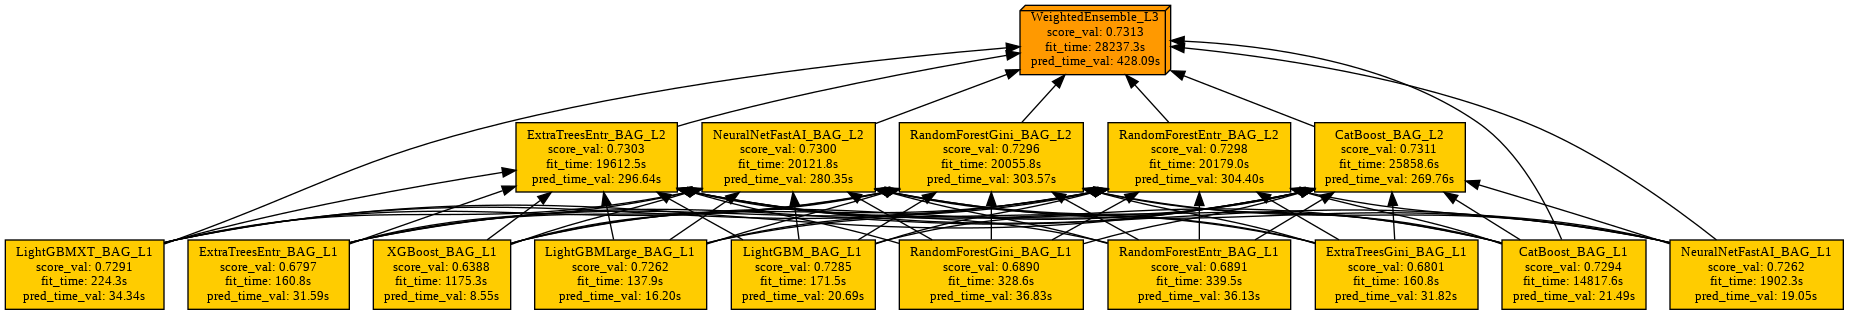

In [19]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image(f'{MODELS_PATH}ensemble_model.png'))

In [20]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
# !zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

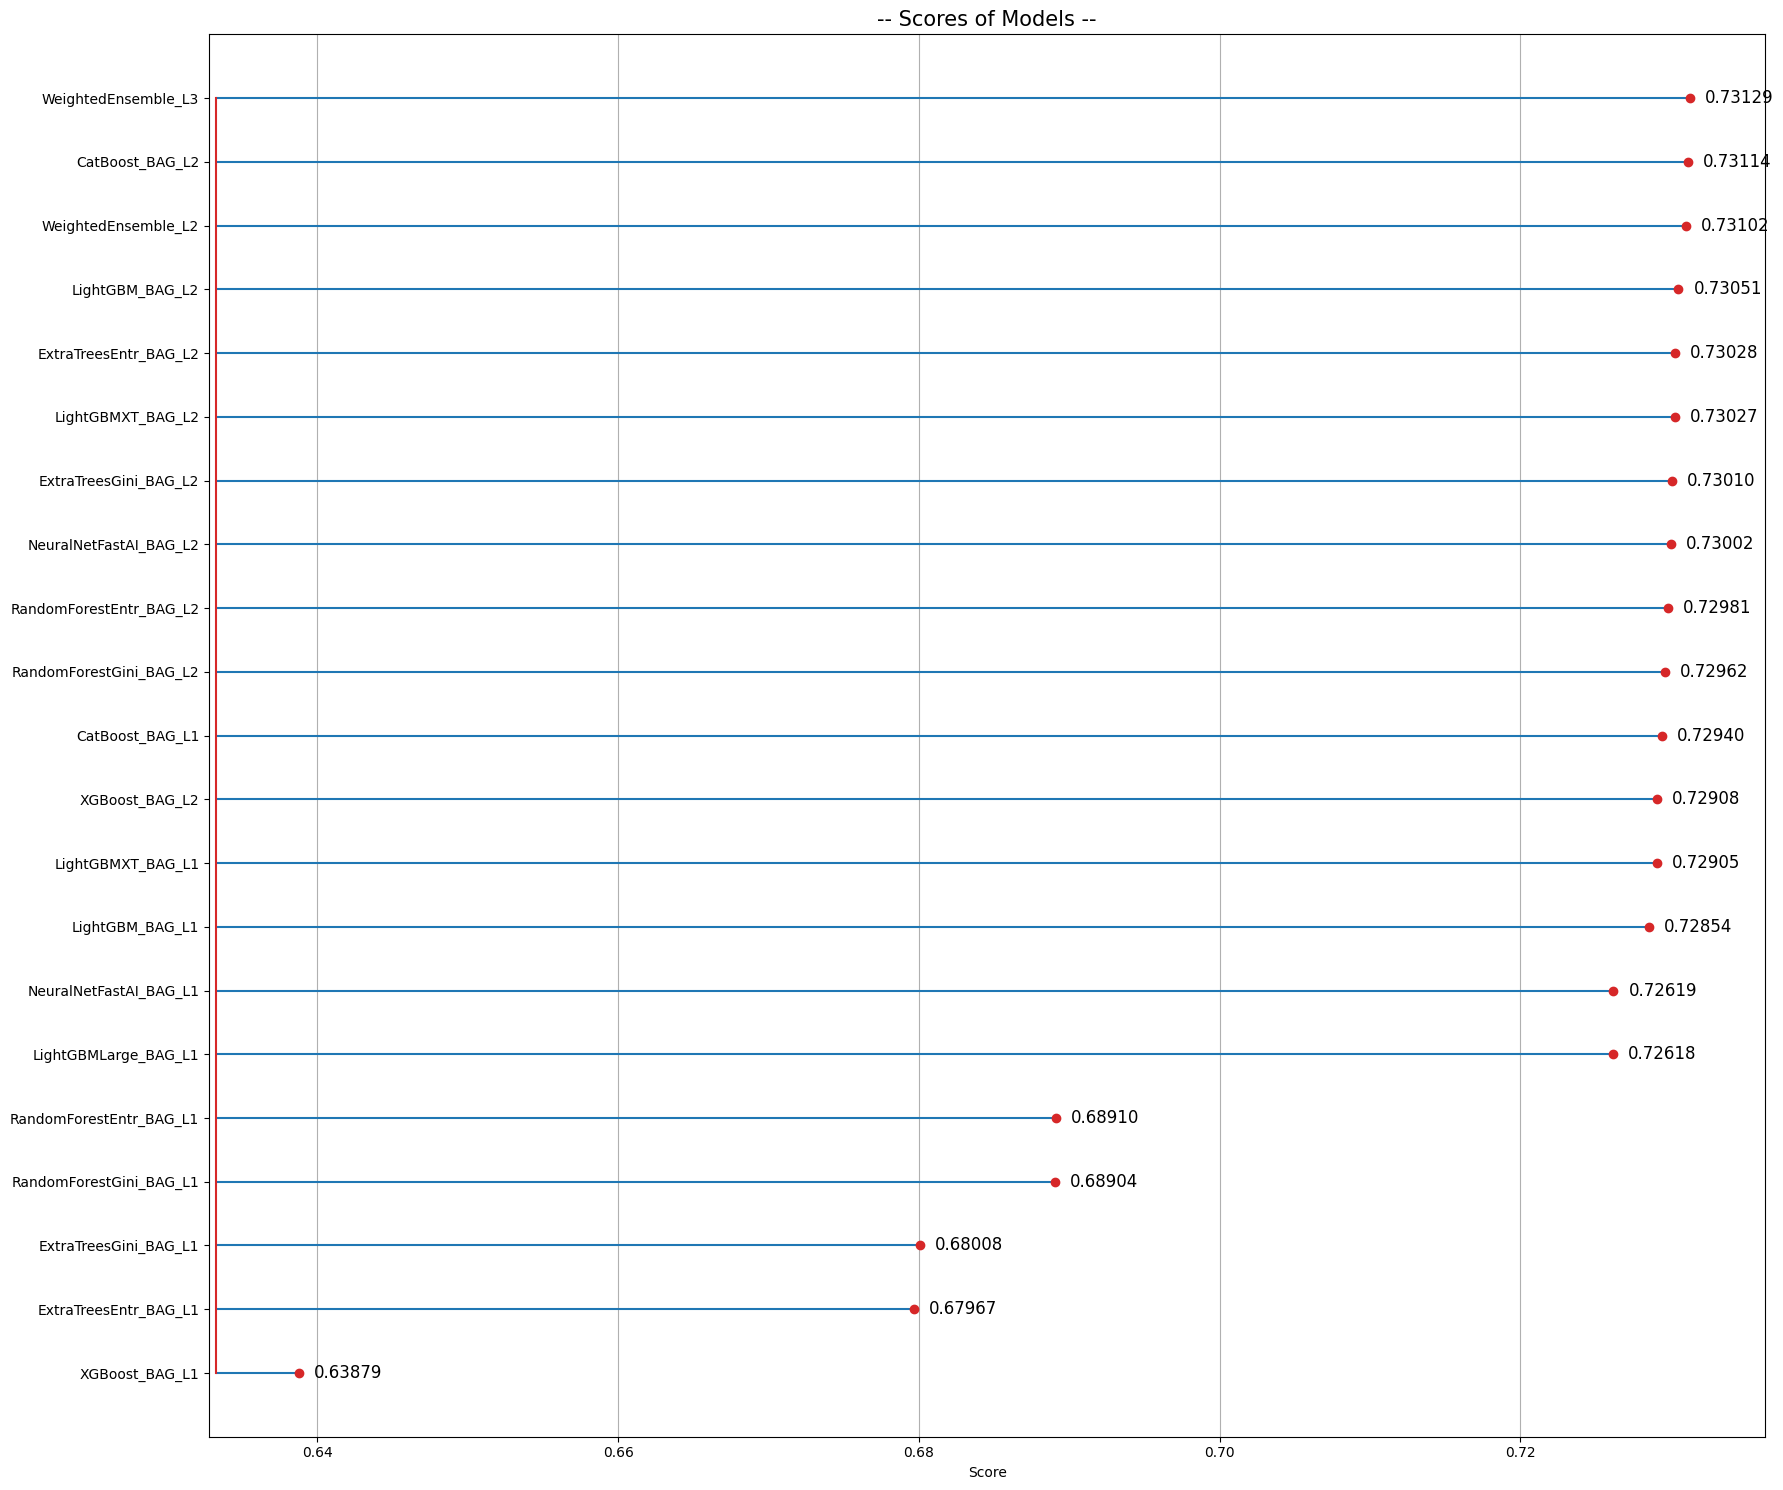

In [21]:
## -- Extract model scores --
result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 15))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.005)
plt.xlabel('Score')
plt.title('-- Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontdict=dict(size=12))

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [22]:
# predictor.model_names()

In [23]:
# ## -- Permutation Feature Importances --
# feat_imp = predictor.feature_importance(
#                         data = X_test,
#                         # time_limit = 3600,
#                         # model = 'LightGBM_BAG_L1',
#                         # features = None,
#                         # feature_stage = 'transformed',
#                         # subsample_size = 5000,
#                         # num_shuffle_sets = 10,
#                         # include_confidence_band = True,
#                         confidence_level = 0.95,
#                         # silent = False
# ) 

# feat_imp.style.background_gradient(subset=["importance"], cmap="Spectral")

# plt.figure(figsize=(18, 35))
# sns.barplot(data=feat_imp, y=feat_imp.index, x=feat_imp.importance)
# plt.tick_params(axis='y', which='major', labelcolor='r')
# plt.title("Top Features by Permutation")
# plt.tight_layout()
# plt.show()

In [24]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------



In [25]:
## -- OPTIONAL: Remove stored files --
!rm -r {MODELS_PATH}